In [1]:
from torchvision import transforms, datasets
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imshow
import os
from sklearn.metrics import accuracy_score

In [2]:
img_basic_transform = transforms.Compose([transforms.Resize((224, 224)),
    transforms.ToTensor()])
test_img_path = "./test/"
test_dataset = datasets.ImageFolder(test_img_path, transform=img_basic_transform)

In [3]:
class ResidualBlockE(nn.Module):
    def __init__(self, channels, kernel_size=3, leak_rate=0.1):
        super().__init__()
        pad = (kernel_size-1)//2
        self.F = nn.Sequential(nn.Conv2d(channels, channels, kernel_size, 
            padding=pad),nn.BatchNorm2d(channels), nn.LeakyReLU(leak_rate),
            nn.Conv2d(channels, channels, kernel_size, padding=pad),
            nn.BatchNorm2d(channels),nn.LeakyReLU(leak_rate))
    def forward(self, x):
        return x + self.F(x)

In [4]:
class ResidualBottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, leak_rate=0.1):
        super().__init__()
        pad = (kernel_size-1)//2
        bottleneck = out_channels//4 
        self.F = nn.Sequential(nn.BatchNorm2d(in_channels), nn.LeakyReLU(leak_rate),
            nn.Conv2d(in_channels, bottleneck, 1, padding=0),
            nn.BatchNorm2d(bottleneck),nn.LeakyReLU(leak_rate),
            nn.Conv2d(bottleneck, bottleneck, kernel_size, padding=pad),
            nn.BatchNorm2d(bottleneck),nn.LeakyReLU(leak_rate),
            nn.Conv2d(bottleneck, out_channels, 1, padding=0))
        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, padding=0), \
                nn.BatchNorm2d(out_channels))
    def forward(self, x):
        return self.shortcut(x) + self.F(x)
    

# Training

In [5]:
device = torch.device("cuda")
B = 30
D = 224*224 #28px * 28px
C = 3 #rgb
classes = len(os.listdir("./train")) #36
kernel_size = 9
n_filters =  24
leak_rate = 0.28

In [6]:
cnn_res_model = nn.Sequential(ResidualBottleNeck(C, n_filters, kernel_size),
        nn.BatchNorm2d(n_filters), nn.LeakyReLU(leak_rate),ResidualBlockE(n_filters, 
        kernel_size), nn.BatchNorm2d(n_filters), nn.LeakyReLU(leak_rate),
        nn.MaxPool2d((2,2)),ResidualBottleNeck(n_filters, 2*n_filters, kernel_size),
        nn.BatchNorm2d(2*n_filters), nn.LeakyReLU(leak_rate), nn.Dropout(0.2), 
        ResidualBlockE(2*n_filters, kernel_size), nn.BatchNorm2d(2*n_filters),
        nn.LeakyReLU(leak_rate),nn.MaxPool2d((2,2)), ResidualBottleNeck(2*n_filters, 4*n_filters, kernel_size),
        nn.BatchNorm2d(4*n_filters), nn.LeakyReLU(leak_rate), ResidualBlockE(4*n_filters, kernel_size),
        nn.BatchNorm2d(4*n_filters), nn.LeakyReLU(leak_rate), nn.Flatten(),
        nn.Linear(D*n_filters//4, classes))

- These are the components I used for training (since I saved the model)

In [ ]:
loss_func = nn.CrossEntropyLoss()
score_funcs={'Acc':accuracy_score}
T = 6
optimizer = torch.optim.AdamW(cnn_res_model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,  T//2 ,eta_min=0.0001)
performance = train_network(cnn_res_model, loss_func, train_loader, optimizer, 
    scheduler, score_funcs, test_loader, epochs=T, device="cuda", checkpoint_file="best_acc_no_aug.pt")

# Evaluation
- Loading in the model

In [7]:
checkpoint_dict = torch.load('best_acc_no_aug.pt', map_location="cuda")
cnn_res_model.load_state_dict(checkpoint_dict['model_state_dict'])

<All keys matched successfully>

In [8]:
softmax = nn.Softmax(dim=-1)
val_img_path = "./validation/"
val_dataset = datasets.ImageFolder(val_img_path, transform=img_basic_transform)
true_labels = []
predicted_labels = []
misclassified = []
features = []
label_ids = []
with torch.no_grad():
    cnn_res_model.to(device)
    cnn_res_model.eval()
    for image, label in val_dataset:
        logits = cnn_res_model(image.unsqueeze(0).to(device))
        features.append(logits.squeeze().detach().cpu().numpy())
        y_hat = softmax(logits.cpu())
        predicted_labels.append(val_dataset.classes[int(np.argmax(y_hat))])
        true_labels.append(val_dataset.classes[label])
        label_ids.append(int(np.argmax(y_hat)))
        if test_dataset.classes[int(np.argmax(y_hat))] != val_dataset.classes[label]:
             misclassified.append([image, test_dataset.classes[int(np.argmax(y_hat))], \
                val_dataset.classes[label], y_hat.max()]) #stores img, y_true, y_pred, and prob                                    

6.267806267806268% are misclassified


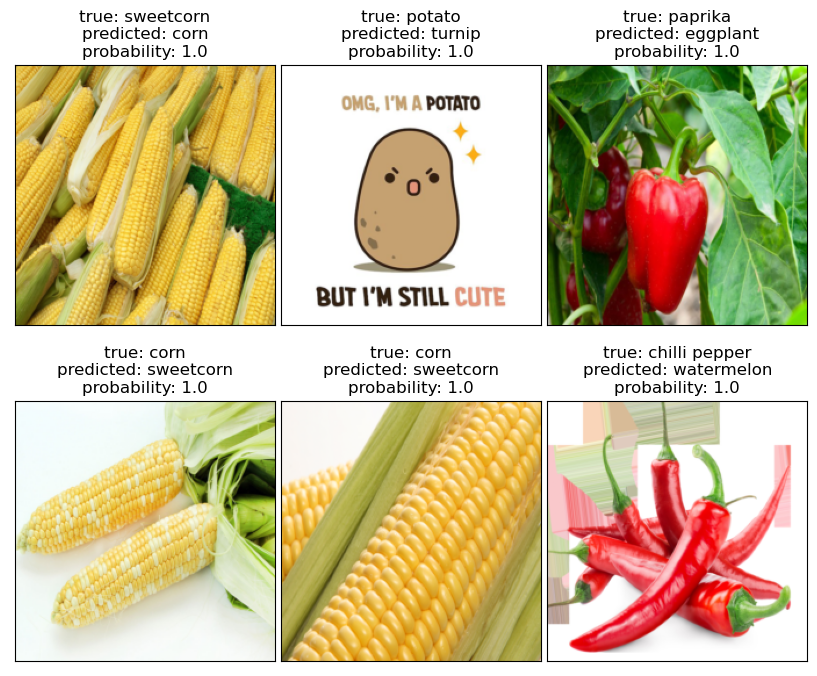

In [9]:
def Sort(pred):
    pred.sort(key = lambda x: x[3]) #sort using prob
    return pred 
print(str(len(misclassified)/len(val_dataset)*100)+"% are misclassified")
sorted_pred = Sort(misclassified) #creates sorted list of descending probabilities
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    x_example, y_pred, y_example, prob = sorted_pred[-(i+1)]
    ax.imshow(x_example.permute(1, 2, 0))
    ax.set_title("true: "+y_example+"\npredicted: "+y_pred+"\nprobability: "+str(prob.item())[:4], fontsize = 12)
plt.tight_layout(pad=0.1)
plt.show()

    

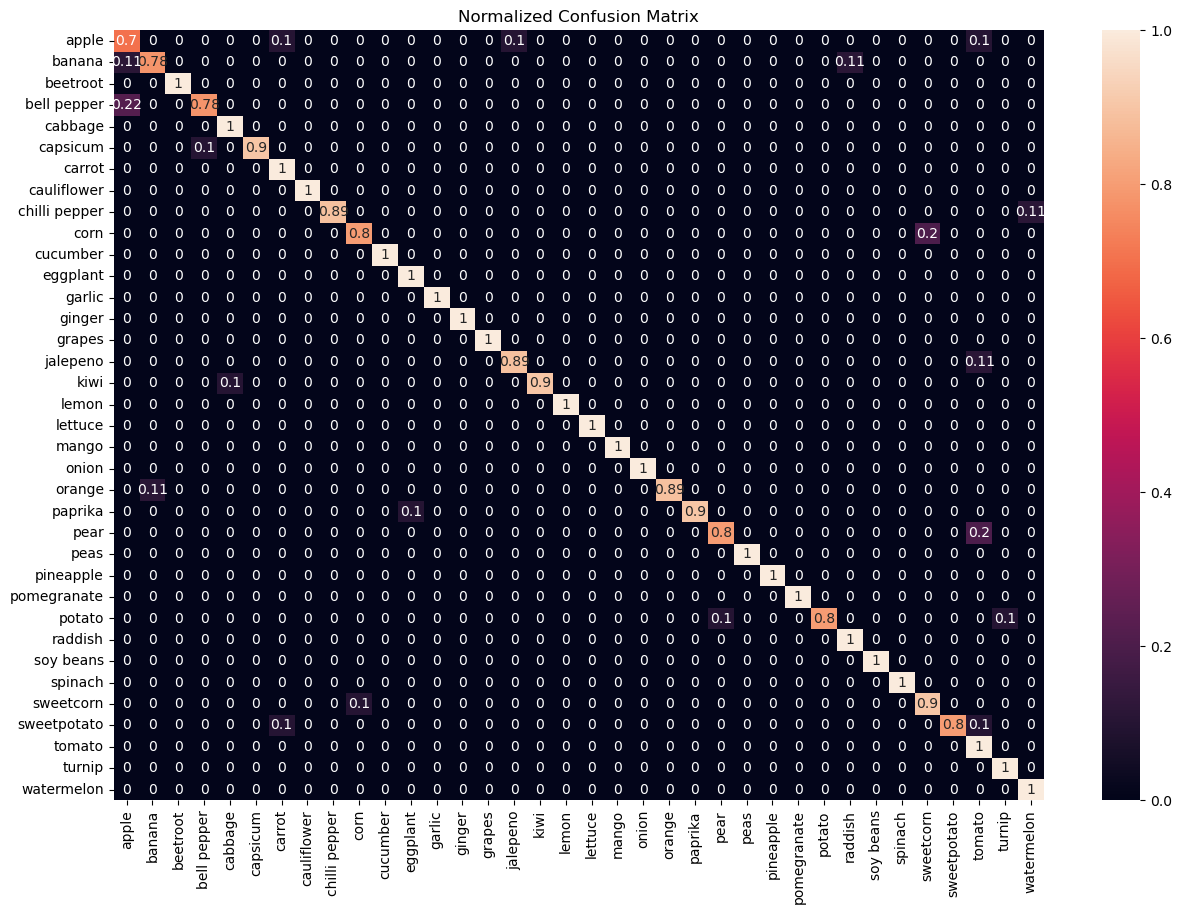

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(true_labels)), 
            yticklabels = sorted(set(true_labels)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

# Evaluate Custom Images

In [11]:
def predict(path):
    image = plt.imread(path)
    transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((224, 224)), transforms.ToTensor()])
    pil_img = (transform(image))
    with torch.no_grad():
        cnn_res_model.to(device)
        cnn_res_model.eval()
        logits = cnn_res_model(pil_img.unsqueeze(0).to(device))
        logits.squeeze().detach().cpu().numpy()
        y_hat = softmax(logits.cpu())
    return test_dataset.classes[int(np.argmax(y_hat))], pil_img


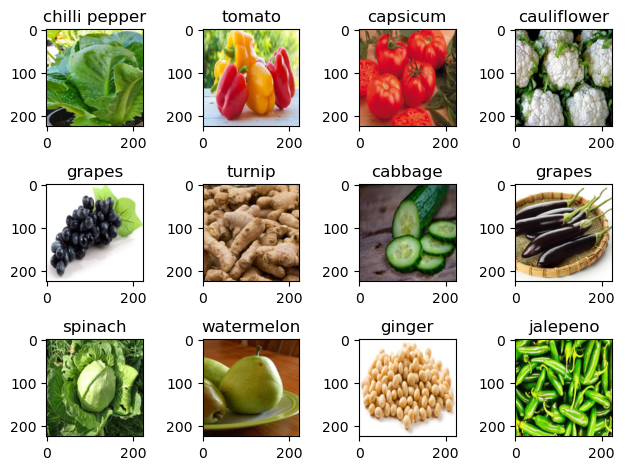

In [12]:
fig, ax = plt.subplots(3, 4)
for i in range (13):
    pred, img = predict(f"{i}.jpg")
    ax[i%3][i%4].imshow(img.permute(1, 2, 0))
    ax[i%3][i%4].set_title(pred)

fig.tight_layout()
plt.show()